In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import numpy as np

### Methodology 

Adoption rate projection for the 19.3M PBB eligible households universe based on Rosenworcel's letter indicating that 16% of ACP recipients had been previously unconnected as of Nov 2022, and that figure increased to 20% by July 2023. Using enrollment totals for those months and our estimate of 17.7M unconnected/ACP-eligible households, those figures translate to 13.6% and 22.39% adoption rates for the unconnected (respectively). 

UPDATED METHODOLOGY
I've found that the logistic curve requires 3 points to fit, and that the curve ends up unrealistically steep when one of the points is too close to the asymptote (i.e. 20% after two years then asymptote at 22%). So my latest methodology is as follows:

Using Rosenworcel's numbers (0% at 1 month, 13.6% at 19 months, and 22.39% at 27 months), I fit a logistic curve assuming the adoption rate approaches 44% over time. 

UPDATED UPDATED METHODOLOGY
Evan wants to see what this curve would look like if we try to optimize High Cost Funding more. That is, assuming that PBB uses all the available High Cost funding ($2.5B by 2031). The adoption rate for that comes out to 32, so I'll scale the curve to that asymptote instead of 22.

In [3]:
## set up logistic curve
def logistic_func(x, L, k, x_0):
    return L / (1 + np.exp(-k * (x - x_0)))

#Adjust the points in these arrays to change the way the curve fits
months = np.array([1, 19, 27])  # 1 for May 2021, 19 for Nov 2022, and 27 for Jul 2023
percentages = np.array([0, 13.6, 22.39])  # The corresponding percentages


# Perform the curve fitting with horizontal asymptote at 44
try:
    params, covariance = curve_fit(lambda x, k, x_0: logistic_func(x, 44, k, x_0), months, percentages, p0=[0.1, 10])
    fit_success = True
except RuntimeError as e:
    print(f"Curve fitting failed: {e}")
    fit_success = False

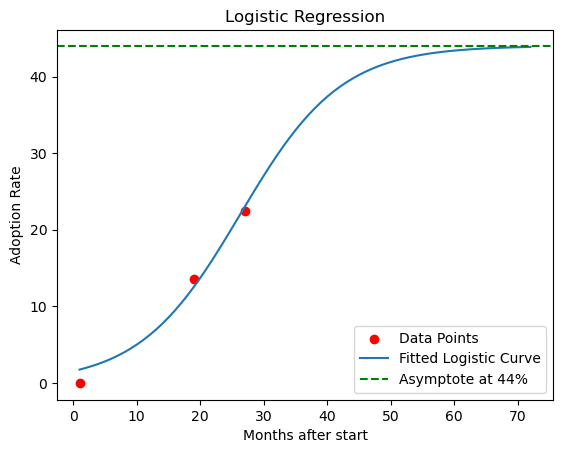

In [4]:
##Create x_vals and y_vals to plot

#x values are months since May 2021. 72 months gives us 6 years
x_vals = np.linspace(1, 72, 72)  
#y_values give us the predicted adoption rate in that month
#horizontal asymptote can be changed here. Make sure it's consistent with above
y_vals = logistic_func(x_vals, 44, *params)

# Plotting to visualize the adoption rates over 72 months. 
plt.scatter(months, percentages, color='red', label='Data Points')
plt.plot(x_vals, y_vals, label='Fitted Logistic Curve')
plt.axhline(y=44, color='green', linestyle='--', label='Asymptote at 44%')
plt.xlabel('Months after start')
plt.ylabel('Adoption Rate')
plt.title('Logistic Regression')
plt.legend()
plt.show()

In [23]:
#calculate the exact peak adoption rate to optimize high cost funding
peak = (1819605874.50/((75*0.0685+30*0.9315)*1.02*12)/19323551)*100
peak

23.254695306684265

In [18]:
#store these in a dataframe (S1) and transform adoption rates to enrollments and costs
S1 = pd.DataFrame({
    'months': x_vals,
    'adoption_rate': y_vals})

#scale down adoption rates so that it peaks "peak", i.e. 32.05%
S1['adoption_rate'] = S1['adoption_rate']*(peak/44)

#enrolled households found by multiplying the adoption rate by the eligible households (19.3M)
S1['enrolled_hh'] = S1['adoption_rate']/100*19323551

#Cost of the program, per month, 6.85% of the enrolled households by $75 because that is the percentage of 
#eligible households in High Cost deployed areas, then the remaining 93.15% by $30
S1['cost'] = S1['enrolled_hh']*(0.0685*75+0.9315*30)*1.02

S1.head()

,months,adoption_rate,enrolled_hh,cost
0,1.0,1.243305,240250.671598,8.107055e+06
1,2.0,1.402968,271103.172777,9.148146e+06
2,3.0,1.582059,305709.995391,1.031592e+07
3,4.0,1.782654,344472.115203,1.162392e+07
4,5.0,2.006973,387818.482302,1.308661e+07


In [9]:
#Just exporting to update the Data for PBB sheet. You can skip this if re-running
S1.to_csv('/Users/mhamburger94/ESH/Projects/PBB/pbb_cost_approach32pct.csv', index=False)

# Prep Scenarios to be plotted on a line graph

In [19]:
#aggregate adoption rates, costs, and totals by years instead of months so that the 
#data lines up with the High Cost Fund data
# Create a 'year' column to group by years (months 1-12 -> year 1, months 13-24 -> year 2, etc.)
S1['year'] = ((S1['months'] - 1) // 12) + 1
S1.head()

,months,adoption_rate,enrolled_hh,cost,year
0,1.0,1.243305,240250.671598,8.107055e+06,1.0
1,2.0,1.402968,271103.172777,9.148146e+06,1.0
2,3.0,1.582059,305709.995391,1.031592e+07,1.0
3,4.0,1.782654,344472.115203,1.162392e+07,1.0
4,5.0,2.006973,387818.482302,1.308661e+07,1.0


In [20]:
# Aggregate data by 'year'
dfy = S1.groupby('year').agg({
    'cost': 'sum',
    'adoption_rate': 'max',
    'enrolled_hh': 'max'
}).reset_index()

# Display the resulting dfy
dfy

,year,cost,adoption_rate,enrolled_hh
0,1.0,2.012054e+08,4.449495,8.598004e+05
1,2.0,6.900931e+08,13.459850,2.600921e+06
2,3.0,1.534996e+09,24.287303,4.693169e+06
3,4.0,2.158883e+09,29.514039,5.703160e+06
4,5.0,2.384593e+09,30.981866,5.986797e+06
5,6.0,2.441962e+09,31.324831,6.053070e+06


# Bar Graph

In [21]:
##Data on projected High Cost Budget through 2032
#Note the High Cost Fund data was copied and pasted from the Data for PBB spreadsheet

years = [2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031]

# Committed Funds and Potential for Reallocation data
committed_funds = [
    4629464191.22, 3655016800.22, 3655016800.22, 2952943020.53, 2952943020.53,
    2809858316.72, 2809858316.72, 2170712310.72
]

potential_reallocation = [
    0.00, 974447391.00, 974447391.00, 1676521170.69, 1676521170.69,
    1819605874.50, 1819605874.50, 2458751880.50
]

pbb_estimate = dfy['cost'].to_list()
pbb_estimate = [None, None] + pbb_estimate
pbb_estimate

[None,
 None,
 201205383.88878986,
 690093147.0154147,
 1534996338.84225,
 2158883213.1290007,
 2384592875.491211,
 2441961652.5358386]

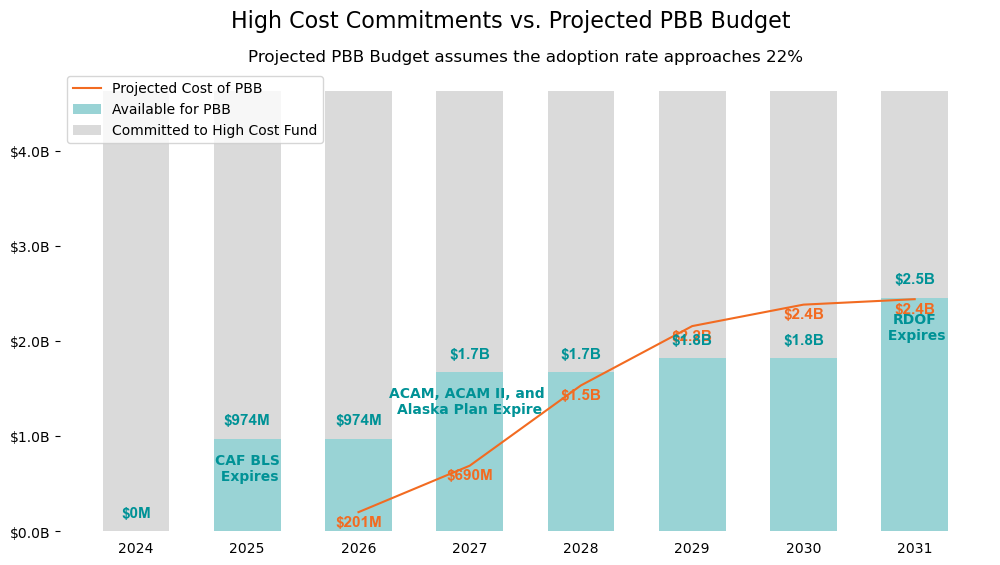

In [22]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Stacked bar chart
bar_width = 0.6
bars1 = plt.bar(years, potential_reallocation, color='#009296',alpha=0.4, width=bar_width, label='Available for PBB')
bars2 = plt.bar(years, committed_funds, bottom=potential_reallocation, color='#4a4a4a',alpha=0.2, width=bar_width, label='Committed to High Cost Fund')

# Line chart
pbb = [np.nan if v is None else v for v in pbb_estimate]

ax1.plot(years, pbb, color='#F26B21', label='Projected Cost of PBB')


# Add data labels
for i, txt in enumerate(pbb):
    if not np.isnan(txt):
        label = f"${txt/1e9:.1f}B" if txt >= 1e9 else f"${txt/1e6:.0f}M"
        ax1.annotate(label, (years[i], pbb[i]), textcoords="offset points", xytext=(0,-10), ha='center', 
                     fontsize=11, weight='bold', fontname = 'Arial', color = '#F26B21')

for i, txt in enumerate(potential_reallocation):
    if not np.isnan(txt):
        label = f"${txt/1e9:.1f}B" if txt >= 1e9 else f"${txt/1e6:.0f}M"
        ax1.annotate(label, (years[i], potential_reallocation[i]), textcoords="offset points", xytext=(0,10), ha='center', 
                     fontsize=11, weight='bold', fontname = 'Arial', color = '#009296')

# Labels and title

# Define a function to format the y-axis labels
def billions(x, pos):
    # Format number in billions
    return f'${x * 1e-9:.1f}B'
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(billions))

plt.suptitle('High Cost Commitments vs. Projected PBB Budget', size=16)
plt.title('Projected PBB Budget assumes the adoption rate approaches 22%', size=12)


#label years, but remove tick marks.
plt.xticks(years)
ax1.tick_params(axis='both', which='both', bottom=False)

plt.legend(loc='upper left', prop={'size': 10})
#remove frame
plt.box(False)

#add anntoations for major jumps in available funds
ax1.annotate('RDOF\n Expires',
             xy=(2031, potential_reallocation[years.index(2031)]),
             xytext=(0,-30),  # Offset the text above the point
             textcoords='offset points',
             ha='center', fontsize=10, color='#009296', fontweight='bold'
            #arrowprops=dict(facecolor='#009296', width = 4, headwidth=10, headlength=4)
            )
ax1.annotate('ACAM, ACAM II, and \nAlaska Plan Expire',
             xy=(2027, potential_reallocation[years.index(2027)]),
             xytext=(0,-30),  # Offset the text above the point
             textcoords='offset points',
             ha='center', fontsize=10, color='#009296', fontweight='bold'
            #arrowprops=dict(facecolor='#009296', width = 4, headwidth=10, headlength=4)
            )
ax1.annotate('CAF BLS\n Expires',
             xy=(2025, potential_reallocation[years.index(2025)]),
             xytext=(0,-30),  # Offset the text above the point
             textcoords='offset points',
             ha='center', fontsize=10, color='#009296', fontweight='bold'
            #arrowprops=dict(facecolor='#009296', width = 4, headwidth=10, headlength=4)
            )
# Display the plot
plt.show()

What if we set the Eligibility criteria to 135%?
This changes the 16.3M to 13.7M. The following is the analogous graph at the 135% level


In [10]:
#store these in a dataframe (S1) and transform adoption rates to enrollments and costs

S2 = pd.DataFrame({
    'months': x_vals,
    'adoption_rate': y_vals})


#scale down adoption rates so that it peaks at 22.39 instead of 44
S2['adoption_rate'] = S2['adoption_rate']*(22.39/44)

##UPDATE
#enrolled households found by multiplying the adoption rate by the eligible households (16.7M)
#this is the 13.7M who are PBB eligible and unconnected at the 135% level + 3M likely to disconnect
S2['enrolled_hh'] = S2['adoption_rate']/100*16724024

#Cost of the program, per month, 6.85% of the enrolled households by $75 because that is the percentage of 
#eligible households in High Cost deployed areas, then the remaining 93.15% by $30
S2['cost'] = S2['enrolled_hh']*(0.0685*75+0.9315*30)

S2.head()

,months,adoption_rate,enrolled_hh,cost
0,1.0,0.885898,148157.799806,4.901430e+06
1,2.0,0.999663,167183.922242,5.530862e+06
2,3.0,1.127272,188525.259865,6.236887e+06
3,4.0,1.270203,212429.086435,7.027685e+06
4,5.0,1.430038,239159.926920,7.912008e+06


In [11]:
S2['year'] = ((S2['months'] - 1) // 12) + 1
# Aggregate data by 'year'
dfz = S2.groupby('year').agg({
    'cost': 'sum',
    'adoption_rate': 'max',
    'enrolled_hh': 'max'
}).reset_index()
#make list
est = dfz['cost'].to_list()
est = [None, None] + est
est

[None,
 None,
 121646420.8223726,
 417222241.9996074,
 928040825.6809527,
 1305235529.8593886,
 1441696950.7255666,
 1476381442.0625026]

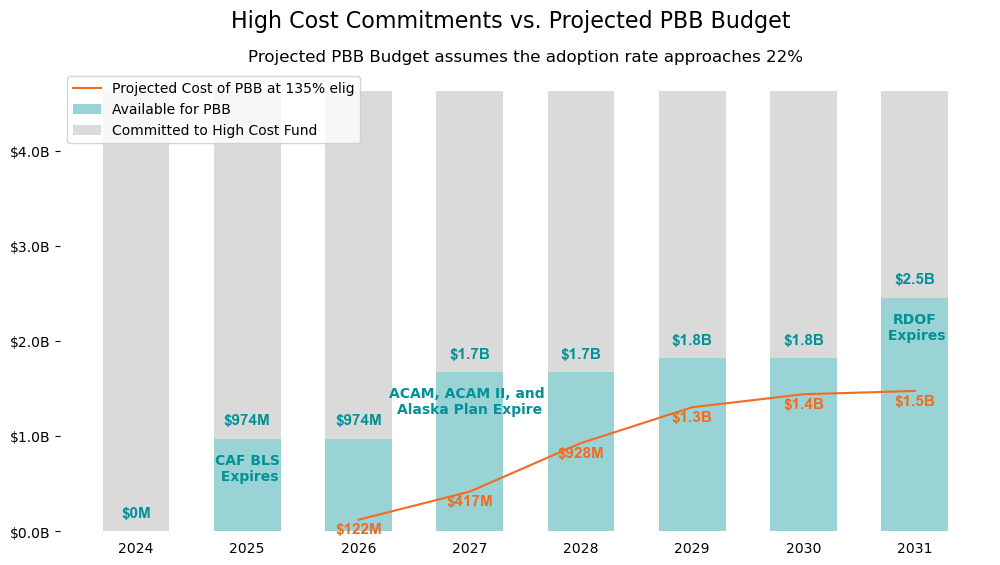

In [12]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12,6))

# Stacked bar chart
bar_width = 0.6
bars1 = plt.bar(years, potential_reallocation, color='#009296',alpha=0.4, width=bar_width, label='Available for PBB')
bars2 = plt.bar(years, committed_funds, bottom=potential_reallocation, color='#4a4a4a',alpha=0.2, width=bar_width, label='Committed to High Cost Fund')

# Line chart
pbb = [np.nan if v is None else v for v in est]

ax1.plot(years, pbb, color='#F26B21', label='Projected Cost of PBB at 135% elig')


# Add data labels
for i, txt in enumerate(pbb):
    if not np.isnan(txt):
        label = f"${txt/1e9:.1f}B" if txt >= 1e9 else f"${txt/1e6:.0f}M"
        ax1.annotate(label, (years[i], pbb[i]), textcoords="offset points", xytext=(0,-10), ha='center', 
                     fontsize=11, weight='bold', fontname = 'Arial', color = '#F26B21')

for i, txt in enumerate(potential_reallocation):
    if not np.isnan(txt):
        label = f"${txt/1e9:.1f}B" if txt >= 1e9 else f"${txt/1e6:.0f}M"
        ax1.annotate(label, (years[i], potential_reallocation[i]), textcoords="offset points", xytext=(0,10), ha='center', 
                     fontsize=11, weight='bold', fontname = 'Arial', color = '#009296')

# Labels and title

# Define a function to format the y-axis labels
def billions(x, pos):
    # Format number in billions
    return f'${x * 1e-9:.1f}B'
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(billions))

plt.suptitle('High Cost Commitments vs. Projected PBB Budget', size=16)
plt.title('Projected PBB Budget assumes the adoption rate approaches 22%', size=12)


#label years, but remove tick marks.
plt.xticks(years)
ax1.tick_params(axis='both', which='both', bottom=False)

plt.legend(loc='upper left', prop={'size': 10})
#remove frame
plt.box(False)

#add anntoations for major jumps in available funds
ax1.annotate('RDOF\n Expires',
             xy=(2031, potential_reallocation[years.index(2031)]),
             xytext=(0,-30),  # Offset the text above the point
             textcoords='offset points',
             ha='center', fontsize=10, color='#009296', fontweight='bold'
            #arrowprops=dict(facecolor='#009296', width = 4, headwidth=10, headlength=4)
            )
ax1.annotate('ACAM, ACAM II, and \nAlaska Plan Expire',
             xy=(2027, potential_reallocation[years.index(2027)]),
             xytext=(0,-30),  # Offset the text above the point
             textcoords='offset points',
             ha='center', fontsize=10, color='#009296', fontweight='bold'
            #arrowprops=dict(facecolor='#009296', width = 4, headwidth=10, headlength=4)
            )
ax1.annotate('CAF BLS\n Expires',
             xy=(2025, potential_reallocation[years.index(2025)]),
             xytext=(0,-30),  # Offset the text above the point
             textcoords='offset points',
             ha='center', fontsize=10, color='#009296', fontweight='bold'
            #arrowprops=dict(facecolor='#009296', width = 4, headwidth=10, headlength=4)
            )
# Display the plot
plt.show()

In [13]:
dfz

,year,cost,adoption_rate,enrolled_hh
0,1.0,1.216464e+08,3.170420,5.302218e+05
1,2.0,4.172222e+08,9.590611,1.603936e+06
2,3.0,9.280408e+08,17.305548,2.894184e+06
3,4.0,1.305236e+09,21.029779,3.517025e+06
4,5.0,1.441697e+09,22.075657,3.691938e+06
5,6.0,1.476381e+09,22.320032,3.732807e+06
